# Active Learning Notebook

Test out using [modAL](https://modal-python.readthedocs.io/en/latest/index.html) with PyMKS.

Todo List:

 - Make work with all the data already evaluated for speedier evaluation
 - Implement with multiple runs and plot uncertainty
 - Implment iGS
 - Make it all functional to some degree
 - PR into PyMKS for an active learning notebook

In [41]:
import numpy as np
import dask.array as da
from dask_ml.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
    solve_fe
)

from toolz.curried import curry, pipe, valmap, itemmap, iterate, do
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI
import tqdm
import types
from pymks.fmks.func import sequence

## Functions for evaluating learners

Following are functions for evaluating learners. The `oracle_func` generates the `y_data` given some `x_data`. We're assuming that it's expensive to use the oracle. Hence why we need active learning.

In [2]:
@curry
def iterate_times(func, times, value):
    iter_ = iterate(func, value)
    for _ in tqdm.tqdm(range(times)):
        next(iter_)
    return next(iter_)

In [47]:
@curry 
def oracle_instance(oracle_func, query_instance):
    _, query_value = query_instance
    query_value = query_value.reshape(1, -1)
    return query_value, oracle_func(query_value)

@curry
def update_learner(oracle_func, x_pool, x_test, y_test, learner):
    query = sequence(
        learner.query,
        oracle_instance(oracle_func),
    )
    return pipe(
        learner,
        do(lambda x: x.teach(*query(x_pool))),
        do(lambda x: x.scores.append(x.score(x_test, y_test)))
    )

@curry
def evaluate_learner(oracle_func, x_pool, x_test, y_test, n_query, learner):
    learner.scores = [learner.score(x_test, y_test)]
    return iterate_times(
        update_learner(oracle_func, x_pool, x_test, y_test),
        n_query,
        learner
    )

## Generate Data Functions

Functions to generate the microstructure. The microstructures are stochastically generated from 6 nominal classes.

In [23]:
def shuffle(data):
    tmp = np.array(data)
    np.random.shuffle(tmp)
    return da.from_array(tmp, chunks=data.chunks)

def generate_x(shape, seed):
    da.random.seed(seed)
    np.random.seed(seed)

    tmp = [
        generate_multiphase(shape=shape, grain_size=x, volume_fraction=(0.5, 0.5), chunks=50, percent_variance=0.15)
        for x in [(15, 2), (2, 15), (7, 7), (9, 3), (3, 9), (2, 2)]
    ]
    return np.array(shuffle(da.concatenate(tmp)))

## Functions to generate models

Here we use the GPR model as it returns a probability that's required by the `ActiveLearner` class.

In [24]:
def pca_steps():
    return (
        ("reshape", GenericTransformer(
            lambda x: x.reshape(x.shape[0], x_data.shape[1], x_data.shape[2])
        )),
        ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
        ("correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=31, correlations=[(0, 1), (1, 1)])),
        ('flatten', GenericTransformer(lambda x: x.reshape(x.shape[0], -1))),
        ('pca', IncrementalPCA(n_components=3, svd_solver='full')),
    )

In [25]:
def make_gp_model():
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
    regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    return Pipeline(steps=pca_steps() + (
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', regressor),
    ))

def make_linear_model():
    return Pipeline(steps=pca_steps() + (
        ('poly', PolynomialFeatures(degree=3))
        ('regressor', LinearRegression()),
    ))

def pca_model():
    return Pipeline(steps=pca_steps())

## The Oracle

The oracle function is an FE simulation on the 2D grid.

In [44]:
@curry
def oracle_func(shape, x_data):
    y_stress = solve_fe(x_data.reshape((-1,) + shape),
                        elastic_modulus=(1.3, 2.5),
                        poissons_ratio=(0.42, 0.35),
                        macro_strain=0.001)['stress'][..., 0]

    return np.array(da.average(y_stress.reshape(y_stress.shape[0], -1), axis=1))

## Helper Functions

In [27]:
def plot_parity(y_test, y_predict, label='Testing Data'):
    pred_data = np.array([y_test, y_predict])
    line = np.min(pred_data), np.max(pred_data)
    plt.plot(pred_data[0], pred_data[1], 'o', label=label)
    plt.plot(line, line, '-', linewidth=3, color='k')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    return plt

In [28]:
def three_way_split(x_data, props, random_state):
    x_0, x_ = train_test_split(x_data, train_size=props[0], random_state=random_state)
    x_1, x_2 = train_test_split(x_, train_size=props[1] / (1 - props[0]), random_state=random_state)
    return flatten(x_0), flatten(x_1), flatten(x_2)

In [29]:
def flatten(x_data):
    return x_data.reshape(x_data.shape[0], -1)

## Greedy Sampling on the x_data GSx

In [87]:
def split_on_ids(arr, ids):
    mask = np.zeros(len(arr), dtype=bool)
    mask[ids] = True
    return arr[mask], arr[~mask]
    
def calc_distances(d0, d1):
    return np.linalg.norm(d0[:, None, :] - d1[None, :, :], ord=2, axis=-1)

def next_sample(labeled_samples, scores):
    scores_labeled, scores_unlabeled = split_on_ids(scores, labeled_samples)
    _, unlabeled_ids = split_on_ids(np.arange(len(scores)), labeled_samples)
    if len(scores_labeled) == 0:
        scores_labeled = np.mean(scores_unlabeled, axis=0)[None]
    distances_nk = calc_distances(scores_unlabeled, scores_labeled)
    distances_n = np.min(distances_nk, axis=1)
    return unlabeled_ids[np.argmax(distances_n)]
                                         
def gsx_query(model, x_pool):
    if not hasattr(model, 'gsx_data'):
        model.gsx_data = [], pca_model().fit_transform(x_pool)
    labeled_samples, scores = model.gsx_data
    next_id = next_sample(labeled_samples, scores)
    model.gsx_data = (labeled_samples + [next_id], scores)
    return next_id, x_pool[next_id]

def gsy_query(model, x_pool):
    if not hasattr(model, 'labeled_samples'):
        model.labeled_samples = []
    y_pool = model.predict(x_pool)
    next_id = next_sample(model.labeled_samples, y_pool.reshape(-1, 1))
    model.labeled_samples = model.labeled_samples + [next_id]
    return next_id, x_pool[next_id]

# Active Learning!

## Generate Data

In [80]:
grid_shape = (41, 41)
n_sample_per_class = 100
x_data = generate_x((n_sample_per_class,) + grid_shape, 5)
x_pool, x_test, x_train = three_way_split(x_data, (0.8, 0.17), 99)
oracle = oracle_func(grid_shape)

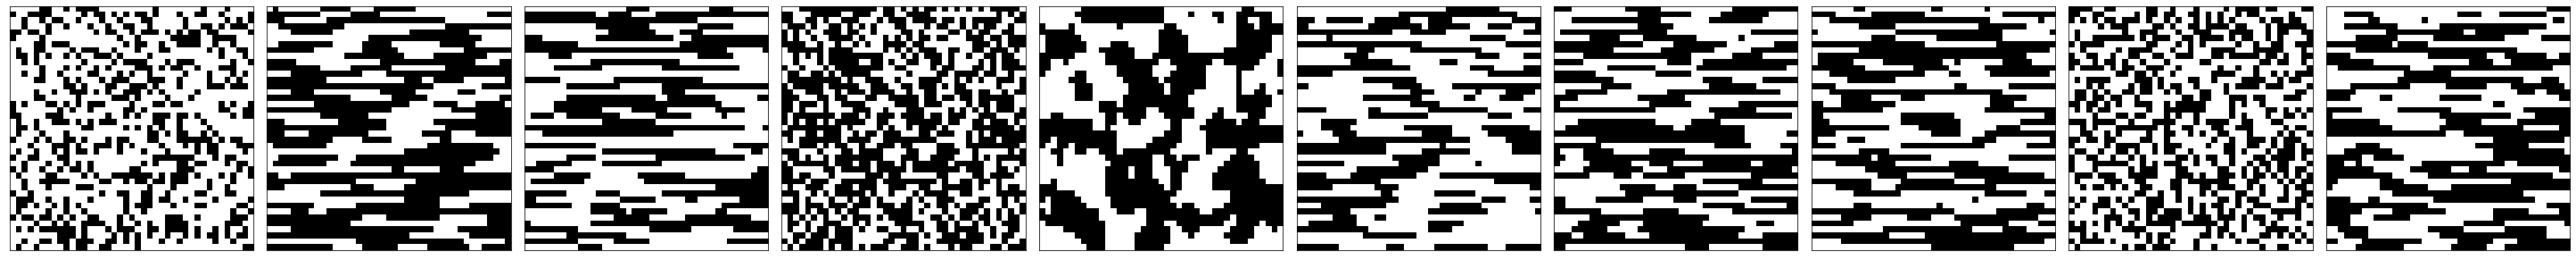

In [81]:
plot_microstructures(*x_data[:10], cmap='gray', colorbar=False);

In [82]:
print(x_test.shape)
print(x_train.shape)
print(x_pool.shape)
print(x_data.shape)

(102, 1681)
(18, 1681)
(480, 1681)
(600, 41, 41)


## Generate the necessary oracle data

In [83]:
%%time
y_test = oracle(x_test)

CPU times: user 5min 24s, sys: 1min 32s, total: 6min 57s
Wall time: 1min 37s


In [84]:
%%time
y_train = oracle(x_train)

CPU times: user 57.5 s, sys: 16.3 s, total: 1min 13s
Wall time: 17.7 s


## Set up the active learners

One is a GPR using the maximum std and the other is random

In [92]:
std_learner = ActiveLearner(
    estimator=make_gp_model(),
    query_strategy=lambda model, x_: pipe(
        model.predict(x_, return_std=True)[1],
        np.argmax,
        lambda i: (i, x_[i])
    ),
    X_training=x_train,
    y_training=y_train
)


random_learner = ActiveLearner(
    estimator=make_gp_model(),
    query_strategy=lambda model, x_: pipe(
        np.random.randint(0, len(x_)),
        lambda i: (i, x_[i])
    ),
    X_training=x_train,
    y_training=y_train
)


gsx_learner = ActiveLearner(
    estimator=make_gp_model(),
    query_strategy=gsx_query,
    X_training=x_train,
    y_training=y_train
)


gsy_learner = ActiveLearner(
    estimator=make_gp_model(),
    query_strategy=gsy_query,
    X_training=x_train,
    y_training=y_train
)

ensemble_learner = CommitteeRegressor(
    learner_list=[
        ActiveLearner(
            estimator=make_gp_model(),
            X_training=x_train_,
            y_training=y_train_
        )
        for x_train_, y_train_ in zip(np.array_split(x_train, 5), np.array_split(y_train, 5))
    ],
    query_strategy=max_std_sampling
)

## required because CommitteeRegressor does not have a score function

def score(self, x_true, y_true):
    y_pred = self.predict(x_true)
    return r2_score(y_true, y_pred)

ensemble_learner.score = types.MethodType(score, ensemble_learner)
    
bayes_learner = BayesianOptimizer(
    estimator=make_gp_model(),
    X_training=x_train,
    y_training=y_train,
    query_strategy=max_EI
)


learners = dict(
    std=std_learner,
    random=random_learner,
    ensemble=ensemble_learner,
    bayes=bayes_learner,
    gsx=gsx_learner,
    gsy=gsy_learner
)

## Run the learners

In [93]:
def evaluate_item(item):
    name, learner = item
    print('evaluating', name)
    return name, evaluate_learner(oracle, x_pool, x_test, y_test, 20, learner)

learners_updated = itemmap(evaluate_item, learners)

evaluating std


100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


evaluating random


100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


evaluating ensemble


100%|██████████| 20/20 [01:19<00:00,  3.99s/it]


evaluating bayes


100%|██████████| 20/20 [00:37<00:00,  1.85s/it]


evaluating gsx


100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


evaluating gsy


100%|██████████| 20/20 [00:40<00:00,  2.02s/it]


## The results

(0.6, 1.0)

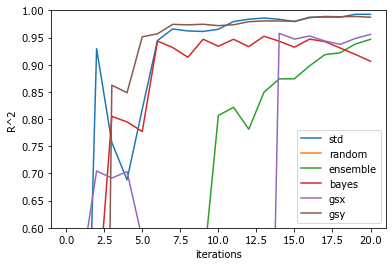

In [97]:
for k, v in learners_updated.items():
    plt.plot(v.scores, label=k)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0.6, 1)

## Check what the accuracy actually looks like

In [79]:
y_pred_std = learner_accuracy['std'][1].predict(x_test)
y_pred_random = learner_accuracy['random'][1].predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

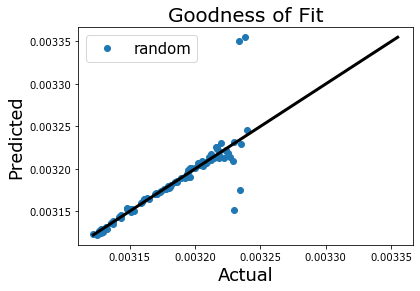

In [89]:
plot_parity(y_test, y_pred_random, label='random')

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

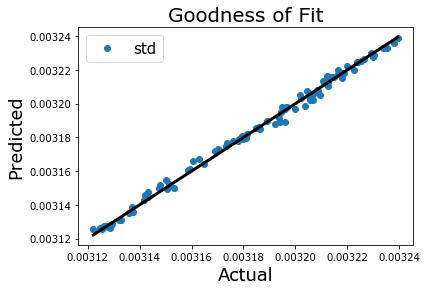

In [90]:
plot_parity(y_test, y_pred_std, label='std')

## Sandbox

In [36]:
out = evaluate_learner(oracle, x_pool, evaluate_func(x_test, y_test), 30, gsx_learner)

100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


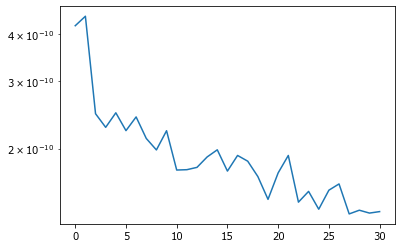

In [37]:
plt.semilogy(out[0])